In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

In [51]:
from pysolotools.consumers.solo import Solo
from pysolotools.stats.analyzers.image_analysis_analyzer import (
    LaplacianStatsAnalyzer,
    PowerSpectrumStatsAnalyzer,
    WaveletTransformStatsAnalyzer,
)
from pysolotools.stats.analyzers.bbox_analyzer import BBoxHeatMapStatsAnalyzer, BBoxSizeStatsAnalyzer
from pysolotools.stats.handler import StatsHandler

#### Initialize SOLO object

In [4]:
data_dir_path = "<SOLO-DATASET-PATH>"
solo = Solo(data_dir_path)

#### Initialize Analyzers and Handler

In [5]:
laplacian_analyzer = LaplacianStatsAnalyzer(solo)
psd_analyzer = PowerSpectrumStatsAnalyzer(solo)
wavelet_analyzer = WaveletTransformStatsAnalyzer(solo)

In [6]:
stats_handler = StatsHandler(solo)
result = stats_handler.handle([laplacian_analyzer, psd_analyzer, wavelet_analyzer])

## Image Analysis Stats

In [11]:
bbox_var = result["LaplacianStatsAnalyzer"]["bbox_var"]
img_var = result["LaplacianStatsAnalyzer"]["img_var"]

### Laplacian

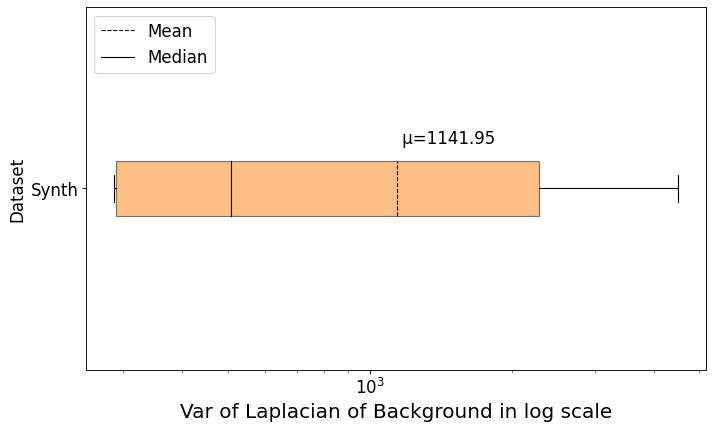

In [58]:
fig, ax = plt.subplots(dpi=80, figsize=(10,6))

box = ax.boxplot(bbox_var,vert=0,patch_artist=True,labels=["Synth"],
                     showmeans=True, meanline=True, showfliers=False,)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
box['boxes'][0].set_facecolor(colors[1])
box['boxes'][0].set_alpha(0.50)
    
box['medians'][0].set_color('black')
box['means'][0].set_color('black')
x, y = box['means'][0].get_xydata()[1]
mean = np.array(bbox_var).mean()
text = ' μ={:.2f}'.format(mean)
ax.annotate(text, xy=(x, y+0.05), fontsize=15)

plt.plot([], [], '--', linewidth=1, color='black', label='Mean')
plt.plot([], [], '-', linewidth=1, color='black', label='Median')
        
plt.legend(fontsize=15, loc="upper left")

plt.xticks(fontsize=15 )
plt.yticks(fontsize=15 )
plt.xscale('log')
plt.xlabel(f"Var of Laplacian of Background in log scale", fontsize=18)
plt.ylabel("Dataset", fontsize=15)

plt.show()

### Wavelet

In [68]:
hist_list = []
for coeff_type in ["horizontal", "vertical", "diagonal"]:
    coeff = result["WaveletTransformStatsAnalyzer"][coeff_type]
    hist = plt.hist(coeff, bins=np.logspace(np.log10(max([min(coeff), np.finfo(float).eps])), np.log10(max(coeff))))
    hist_list.append(hist)
    plt.close()

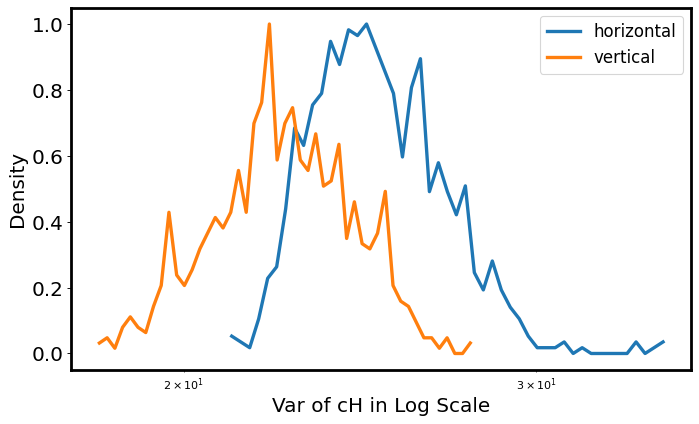

In [78]:
fig, ax = plt.subplots(dpi=80, figsize=(10,6))
colors = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for hist, hist_type in zip(hist_list, ["horizontal", "vertical",]):
    norm_data = (hist[0] - min(hist[0]))/(max(hist[0])-min(hist[0]))
    ax.plot(hist[1][1:],norm_data, linestyle='-',  label=hist_type, linewidth=3, color=next(colors))

ax.set_xscale('log')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel("Var of cH in Log Scale", fontsize=18)
plt.ylabel("Density", fontsize=18)
plt.xticks(fontsize=18 )
plt.yticks(fontsize=18 )

plt.setp(ax.spines.values(), linewidth=2.5)

plt.show()

### Power Spectrum

In [83]:
psd_1d = np.nanmean(result["PowerSpectrumStatsAnalyzer"], axis=0)

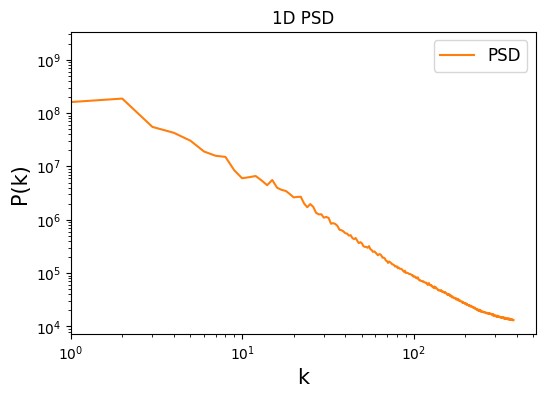

In [89]:
fig, ax = plt.subplots(dpi=100)
colors = (plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax.plot(psd_1d, color=colors[1], label="PSD")

plt.legend(fontsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylabel("P(k)", fontsize=15)
plt.xlabel("k", fontsize=15)
plt.title("1D PSD")
plt.xlim([1, None])
plt.show()

## Obejct Detection Stats

In [5]:
bbox_size_analyzer = BBoxSizeStatsAnalyzer()
bbox_hmap_analyzer = BBoxHeatMapStatsAnalyzer()

In [7]:
stats_handler = StatsHandler(solo)
result = stats_handler.handle([bbox_hmap_analyzer, bbox_size_analyzer])

### BBox Heatmap

In [13]:
bbox_heatmap = result["BBoxHeatMapStatsAnalyzer"]

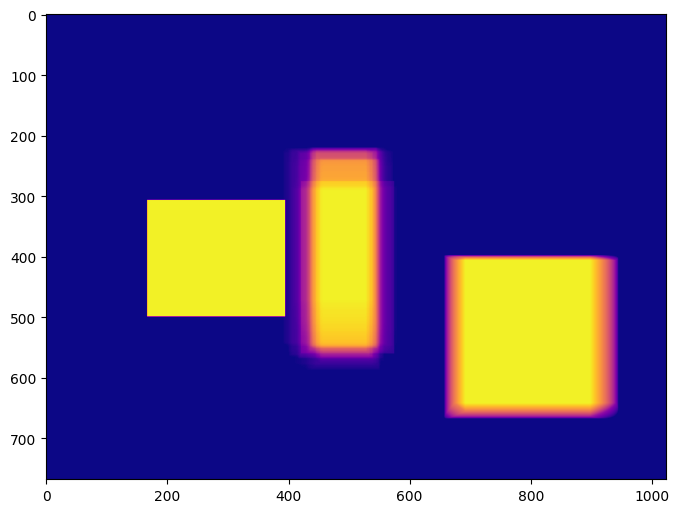

In [14]:
bbox_heatmap_norm = bbox_heatmap / bbox_heatmap.max()
fig, ax = plt.subplots(dpi=100, figsize=(8,8))
pcm = ax.imshow(bbox_heatmap_norm[:,:,0], cmap="plasma", )
plt.show()

### Bounding Box Size Distribution

In [28]:
bbox_size_dist = result["BBoxSizeStatsAnalyzer"]
bbox_size = [[x, "Synth", 1/len(bbox_size_dist)] for x in bbox_size_dist]
df = pd.DataFrame(bbox_size, columns =['val', 'type', 'w'])

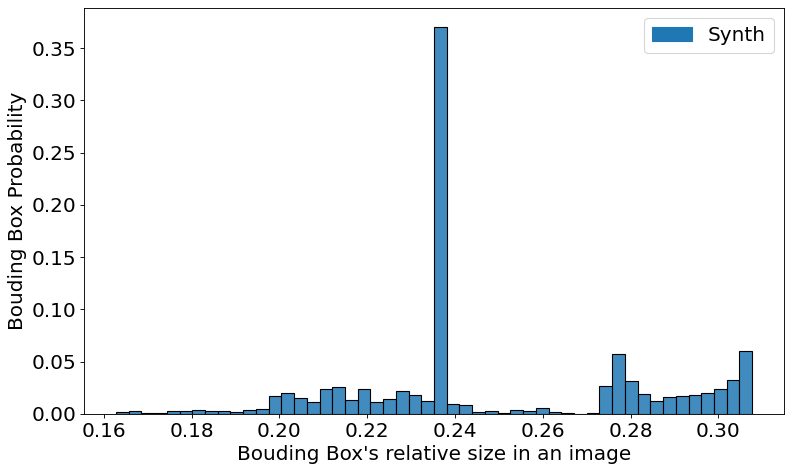

In [49]:
fig, ax = plt.subplots(dpi=80, figsize=(10,6))
sns.histplot(data=df, x="val", hue="type", weights='w', 
             bins=50, multiple="layer", alpha=.85, ax=ax, legend=None)

# where some data has already been plotted to ax
handles, labels = ax.get_legend_handles_labels()

# manually define a new patch 
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
patch1 = mpatches.Patch(color=colors[0], label='Synth')
handles.append(patch1) 


plt.legend(handles=handles, fontsize=18)

ax.set_xlabel("Bouding Box's relative size in an image", fontsize=18)
ax.set_ylabel("Bouding Box Probability", fontsize=18)
ax.yaxis.set_tick_params(labelsize=18)
ax.xaxis.set_tick_params(labelsize=18)

fig.tight_layout()

plt.show()